<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es entrenar un modelo de lenguaje basado en arquitectura de redes recurrentes a partir de un corpus de texto. En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la perplejidad. Parte del ejercicio consiste en estructurar adecuadamente el dataset para este problema.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.losses import SparseCategoricalCrossentropy

2024-04-18 17:49:15.609425: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 17:49:15.609452: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 17:49:15.610631: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 17:49:15.689732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-04-18 17:49:17.685765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 17:49:17.702310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-18 17:49:17.702500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from tensorflow.python.platform import build_info as build
print(f"tensorflow version: {tf.__version__}")
print(f"Cuda Version: {build.build_info['cuda_version']}")
print(f"Cudnn version: {build.build_info['cudnn_version']}")

tensorflow version: 2.14.0
Cuda Version: 11.8
Cudnn version: 8


### Datos
Se utilizará el dataset empleado en el desafío 2, que contiene noticias recientes de la BBC.

fuente: https://www.kaggle.com/datasets/gpreda/bbc-news

In [5]:
df_full_bbc = pd.read_csv('bbc_news/bbc_news.csv')

# keep the two interesting columns
df_bbc_title = df_full_bbc['title']
df_bbc_description = df_full_bbc['description']

df_bbc = pd.DataFrame({'news': df_bbc_title + ' ' + df_bbc_description})

In [6]:
df_bbc.head()

,news
0,Ukraine: Angry Zelensky vows to punish Russian...
1,War in Ukraine: Taking cover in a town under a...
2,Ukraine war 'catastrophic for global food' One...
3,Manchester Arena bombing: Saffie Roussos's par...
4,Ukraine conflict: Oil price soars to highest l...


In [7]:
print("Cantidad de documentos:", df_bbc.shape[0])

Cantidad de documentos: 30841


### Elección del tamaño del contexto

In [8]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [9]:
# Cada noticia se guarda en una lista
news_text = list(df_bbc.loc[:,'news'])
news_text

['Ukraine: Angry Zelensky vows to punish Russian atrocities The Ukrainian president says the country will not forgive or forget those who murder its civilians.',
 'War in Ukraine: Taking cover in a town under attack Jeremy Bowen was on the frontline in Irpin, as residents came under Russian fire while trying to flee.',
 "Ukraine war 'catastrophic for global food' One of the world's biggest fertiliser firms says the conflict could deliver a shock to food supplies.",
 "Manchester Arena bombing: Saffie Roussos's parents on hearing the truth The parents of the Manchester Arena bombing's youngest victim speak about their life since she died.",
 'Ukraine conflict: Oil price soars to highest level since 2008 Consumers are feeling the impact of higher energy costs as fuel prices and household bills jump.',
 'Ukraine war: PM to hold talks with world leaders on further sanctions Boris Johnson is to meet the Canadian and Dutch PMs, as MPs debate new laws targeting oligarchs.',
 'Ukraine war: UK g

In [10]:
# Se segmenta el texto con la utilidad de Keras
news_segmented_sentences = [text_to_word_sequence(sentence) for sentence in news_text]

In [11]:
# calculamos la longitud de cada secuencia
news_length_sentences = [len(sentence) for sentence in news_segmented_sentences]

(array([2.000e+00, 9.000e+00, 2.900e+01, 9.400e+01, 7.920e+02, 2.135e+03,
        7.917e+03, 9.248e+03, 3.731e+03, 2.605e+03, 1.636e+03, 8.850e+02,
        9.440e+02, 4.960e+02, 1.680e+02, 1.110e+02, 3.200e+01, 4.000e+00,
        2.000e+00, 1.000e+00]),
 array([ 7.  ,  9.65, 12.3 , 14.95, 17.6 , 20.25, 22.9 , 25.55, 28.2 ,
        30.85, 33.5 , 36.15, 38.8 , 41.45, 44.1 , 46.75, 49.4 , 52.05,
        54.7 , 57.35, 60.  ]),
 <BarContainer object of 20 artists>)

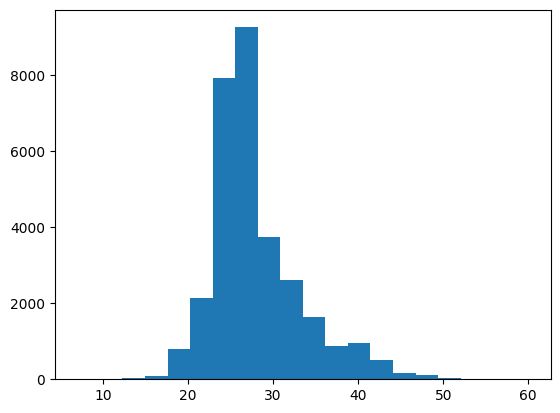

In [12]:
# podemos ver la distribución
plt.hist(news_length_sentences,bins=20)

A partir de la distribución de longitudes de secuencias se seleccionará algún criterio para determinar el máximo tamaño de contexto. En este caso es un percentil, pero  otros criterios también pueden ser válidos con la justificación adecuada.

In [13]:
# el -1 es porque el último token será el target
max_context_size = int(np.percentile(news_length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 35


###  Tokenizar

El tokenizer "aprende" las palabras que se usaran. Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder). El token 0 es reservado y no es asignado ya que se utiliza para designar a palabras fuera del vocabulario aprendido.

In [14]:
tok = Tokenizer()

tok.fit_on_texts(news_segmented_sentences)

# Se convierten las palabras a números (entran palabras -> salen números)
news_tokenized_sentences = tok.texts_to_sequences(news_segmented_sentences)

In [15]:
news_tokenized_sentences

[[34,
  2161,
  877,
  1646,
  2,
  7859,
  80,
  5448,
  1,
  244,
  120,
  13,
  1,
  296,
  21,
  54,
  7374,
  189,
  5008,
  444,
  35,
  255,
  71,
  1169],
 [51,
  3,
  34,
  440,
  1276,
  3,
  5,
  421,
  142,
  137,
  882,
  2541,
  20,
  8,
  1,
  4003,
  3,
  6252,
  10,
  692,
  1208,
  142,
  80,
  259,
  200,
  649,
  2,
  1707],
 [34,
  51,
  24062,
  7,
  644,
  12465,
  56,
  4,
  1,
  664,
  376,
  11055,
  714,
  13,
  1,
  591,
  64,
  2631,
  5,
  816,
  2,
  297,
  1891],
 [67,
  2057,
  2784,
  24063,
  24064,
  504,
  8,
  1352,
  1,
  3178,
  1,
  504,
  4,
  1,
  67,
  2057,
  24065,
  2677,
  1252,
  1144,
  50,
  27,
  130,
  148,
  78,
  172],
 [34,
  591,
  505,
  431,
  4099,
  2,
  1428,
  785,
  148,
  5680,
  5449,
  14,
  2468,
  1,
  573,
  4,
  1117,
  127,
  469,
  10,
  878,
  245,
  6,
  1470,
  308,
  3319],
 [34,
  51,
  161,
  2,
  857,
  500,
  15,
  18,
  445,
  8,
  834,
  1051,
  319,
  251,
  9,
  2,
  569,
  1,
  1736,
  6,
  1708,
  56

In [16]:
max_context_size+1

36

### Organizando y estructurando el dataset

Se tiene en la variable `news_tokenized_sentences` las noticias tokenizadas. Se separará un conjunto de validación, que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad (preplexity).

In [17]:
news_tokenized_sentences_train, news_tokenized_sentences_val, _, _ = train_test_split(news_tokenized_sentences, news_tokenized_sentences, test_size=0.2, random_state=42)

Se realizará un split sobre las oraciones que tienen tamaño mayor al contexto máximo, a fin de generar más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [18]:
news_tok_sent_train = []

for sent in news_tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      news_tok_sent_train.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    news_tok_sent_train.append(sent)

In [19]:
len(news_tok_sent_train)

34153

In [20]:
len(news_tokenized_sentences_train)

24672

Como se puede observar, se pasó de 24672 entradas para `news_tokenized_sentences_train` a 34153 entradas para `news_tok_sent_train`

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [62]:
import math

news_tok_sent_augm_train = []

for sent in news_tok_sent_train:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  news_tok_sent_augm_train.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [63]:
# finalmente se concatenan todas las secuencias de noticias en un único array de numpy
news_train_seqs = np.concatenate(news_tok_sent_augm_train, axis=0)

In [64]:
news_train_seqs.shape

(986246, 36)

Con este nuevo augmentation, se pasó de 34153 entradas para `news_tok_sent_train` a 986246 entradas para `news_train_seqs`. Esta última estrategia aumentó de manera considerable el dataset de train.

De este dataset se tomarán las entradas y los targets que consumirá el sistema en tiempo de entrenamiento

In [65]:
X = news_train_seqs[:,:-1]
y = news_train_seqs[:,-1]

In [66]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'to',
 3: 'in',
 4: 'of',
 5: 'a',
 6: 'and',
 7: 'for',
 8: 'on',
 9: 'is',
 10: 'as',
 11: 'at',
 12: 'after',
 13: 'says',
 14: 'are',
 15: 'with',
 16: 'from',
 17: 'by',
 18: 'world',
 19: 'his',
 20: 'was',
 21: 'will',
 22: 'has',
 23: 'over',
 24: 'cup',
 25: 'be',
 26: 'england',
 27: 'their',
 28: 'have',
 29: 'it',
 30: 'how',
 31: 'but',
 32: 'an',
 33: 'new',
 34: 'ukraine',
 35: 'who',
 36: 'uk',
 37: 'what',
 38: 'first',
 39: 'he',
 40: 'her',
 41: 'us',
 42: 'bbc',
 43: 'people',
 44: 'year',
 45: 'out',
 46: 'been',
 47: 'up',
 48: 'league',
 49: 'win',
 50: 'about',
 51: 'war',
 52: 'they',
 53: 'more',
 54: 'not',
 55: 'two',
 56: 'one',
 57: 'say',
 58: 'that',
 59: 'final',
 60: 'against',
 61: 'police',
 62: 'day',
 63: 'city',
 64: 'could',
 65: 'were',
 66: 'years',
 67: 'manchester',
 68: '1',
 69: 'man',
 70: 'into',
 71: 'its',
 72: '2022',
 73: 'why',
 74: 'being',
 75: 'time',
 76: 'this',
 77: 'can',
 78: 'she',
 79: '2023',
 80: 'russian',

In [67]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

39729

In [68]:
# El índice para cada palabra, ordenada de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'to': 2, 'in': 3, 'of': 4, 'a': 5, 'and': 6, 'for': 7, 'on': 8, 'is': 9, 'as': 10, 'at': 11, 'after': 12, 'says': 13, 'are': 14, 'with': 15, 'from': 16, 'by': 17, 'world': 18, 'his': 19, 'was': 20, 'will': 21, 'has': 22, 'over': 23, 'cup': 24, 'be': 25, 'england': 26, 'their': 27, 'have': 28, 'it': 29, 'how': 30, 'but': 31, 'an': 32, 'new': 33, 'ukraine': 34, 'who': 35, 'uk': 36, 'what': 37, 'first': 38, 'he': 39, 'her': 40, 'us': 41, 'bbc': 42, 'people': 43, 'year': 44, 'out': 45, 'been': 46, 'up': 47, 'league': 48, 'win': 49, 'about': 50, 'war': 51, 'they': 52, 'more': 53, 'not': 54, 'two': 55, 'one': 56, 'say': 57, 'that': 58, 'final': 59, 'against': 60, 'police': 61, 'day': 62, 'city': 63, 'could': 64, 'were': 65, 'years': 66, 'manchester': 67, '1': 68, 'man': 69, 'into': 70, 'its': 71, '2022': 72, 'why': 73, 'being': 74, 'time': 75, 'this': 76, 'can': 77, 'she': 78, '2023': 79, 'russian': 80, 'some': 81, 'off': 82, 'former': 83, 'three': 84, 'watch': 85, '2': 86, 'home'

### Definir el modelo

A continuación se definirá el modelo a entrenar.

In [69]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 39729 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_shape=(max_context_size,)))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 35, 5)             198650    
                                                                 
 lstm_4 (LSTM)               (None, 35, 64)            17920     
                                                                 
 dropout_2 (Dropout)         (None, 35, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 39730)             1311090   
                                                                 
Total params: 1562764 (5.96 MB)
Trainable params: 1562

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, se definirá un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [70]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        # nos movemos en todas las secuencias de los datos de validación
        for seq in self.val_data:

          # armamos todas las subsecuencias
          subseq = [seq[:i] for i in range(len(seq))]
          target = [seq[i] for i in range(len(seq))]
          bb = pad_sequences(subseq, maxlen=max_context_size, padding='pre')

          # utilizamos el modelo para que haga su predicción en cada subsecuencia
          # (son las probabilidades condicionadas)
          predictions = self.model.predict(bb,verbose=0)

          # en `probs`iremos guardando las probabilidades de los términos target
          probs = []

          for idx_seq, idx_vocab in enumerate(target):
              probs.append(predictions[idx_seq,idx_vocab])

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/len(target)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)} \n')

### Entrenamiento

In [71]:
hist = model.fit(X, y, epochs=50, callbacks=[PplCallback(news_tokenized_sentences_val)], batch_size=32)

Epoch 1/50
30821/30821 [==============================] - ETA: 0s - loss: 7.4211
 mean perplexity: 4748.885729242825 

30821/30821 [==============================] - 543s 17ms/step - loss: 7.4211
Epoch 2/50
30821/30821 [==============================] - ETA: 0s - loss: 7.0125
 mean perplexity: 5315.4898774667545 

30821/30821 [==============================] - 513s 17ms/step - loss: 7.0125
Epoch 3/50
30821/30821 [==============================] - ETA: 0s - loss: 6.8149

/tmp/ipykernel_419/2203878049.py:38: RuntimeWarning: divide by zero encountered in log
  scores.append(np.exp(-np.sum(np.log(probs))/len(target)))



 mean perplexity: inf 

30821/30821 [==============================] - 521s 17ms/step - loss: 6.8149
Epoch 4/50
25338/30821 [=======================>......] - ETA: 36s - loss: 6.7131

KeyboardInterrupt: 

Podemos observar que el "mean perplexity" va en aumento, y que el entrenamiento está tomando demasiado tiempo, por lo que se detiene el fit(). 

Se entiende que la arquitectura del modelo no es la adecuada. Se incrementará la complejidad de la red y se agregarán capas bidireccionales. También se aumentará las dimensiones del embedding.

Al ser el dataset bastante grande, se propone reducir el tamaño del mismo para acelerar los tiempos de entrenamiento, ya que el modelo ahora es todavía más complejo.

In [31]:
news_tok_sent_augm_train_reduced = []

for sent in news_tok_sent_train:
  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-4, len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  news_tok_sent_augm_train_reduced.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

# finalmente se concatenan todas las secuencias de noticias en un único array de numpy
news_train_seqs_reduced = np.concatenate(news_tok_sent_augm_train_reduced, axis=0)

In [32]:
news_train_seqs_reduced.shape

(102459, 36)

Previamente teníamos 986246 entradas para `news_train_seqs`. Ahora hemos reducido esa cantidad a 102459 para `news_train_seqs_reduced`

In [33]:
X_reduced = news_train_seqs_reduced[:,:-1]
y_reduced = news_train_seqs_reduced[:,-1]

Ahora achicamos el dataset de validación.

In [34]:
import math

upper_limit = math.floor(len(news_tokenized_sentences_val)*0.90)
news_tokenized_sentences_val_reduced = news_tokenized_sentences_val[:-upper_limit]
len(news_tokenized_sentences_val_reduced)

617

Llevamos al dataset de validación `news_tokenized_sentences_val` de 6169 entradas a 617 para `news_tokenized_sentences_val_reduced`.

In [35]:
model2 = Sequential()

# Embedding:
model2.add(Embedding(input_dim=vocab_size+1, output_dim=120, input_shape=(max_context_size,)))

# Capas LSTM bidireccionales
model2.add(Bidirectional(LSTM(128, return_sequences=True)))
#model2.add(Dropout(0.2))

# Agregar más capas LSTM bidireccionales
# model2.add(Bidirectional(LSTM(128, return_sequences=True)))
#model2.add(Dropout(0.2))

model2.add(Bidirectional(LSTM(128)))  # La última capa LSTM bidireccional no lleva return_sequences
model2.add(Dense(64, activation='relu'))

model2.add(Dropout(0.2))

# Predicción de clasificación con softmax
model2.add(Dense(vocab_size+1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model2.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 120)           4767600   
                                                                 
 bidirectional (Bidirection  (None, 35, 256)           254976    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 39730)            

In [37]:
hist2 = model2.fit(X_reduced, y_reduced, epochs=50, callbacks=[PplCallback(news_tokenized_sentences_val_reduced)], batch_size=32)

Epoch 1/50
3202/3202 [==============================] - ETA: 0s - loss: 7.5762
 mean perplexity: 4229.378961692365 

3202/3202 [==============================] - 72s 22ms/step - loss: 7.5762
Epoch 2/50
3202/3202 [==============================] - ETA: 0s - loss: 6.9064
 mean perplexity: 4701.862278078802 

3202/3202 [==============================] - 62s 19ms/step - loss: 6.9064
Epoch 3/50
3202/3202 [==============================] - ETA: 0s - loss: 6.5205
 mean perplexity: 7718.974934491193 

3202/3202 [==============================] - 61s 19ms/step - loss: 6.5205
Epoch 4/50
3202/3202 [==============================] - ETA: 0s - loss: 6.2015
 mean perplexity: 10665.73363754881 

3202/3202 [==============================] - 60s 19ms/step - loss: 6.2015
Epoch 5/50
3202/3202 [==============================] - ETA: 0s - loss: 5.9062
 mean perplexity: 18287.159183440526 

3202/3202 [==============================] - 61s 19ms/step - loss: 5.9062
Epoch 6/50
3202/3202 [======================

/tmp/ipykernel_419/2203878049.py:38: RuntimeWarning: divide by zero encountered in log
  scores.append(np.exp(-np.sum(np.log(probs))/len(target)))



 mean perplexity: inf 

3202/3202 [==============================] - 62s 19ms/step - loss: 4.9883
Epoch 10/50
3202/3202 [==============================] - ETA: 0s - loss: 4.8051
 mean perplexity: inf 

3202/3202 [==============================] - 60s 19ms/step - loss: 4.8051
Epoch 11/50
3202/3202 [==============================] - ETA: 0s - loss: 4.6341
 mean perplexity: inf 

3202/3202 [==============================] - 61s 19ms/step - loss: 4.6341
Epoch 12/50
3197/3202 [============================>.] - ETA: 0s - loss: 4.4735
 mean perplexity: inf 

3202/3202 [==============================] - 60s 19ms/step - loss: 4.4741
Epoch 13/50
3202/3202 [==============================] - ETA: 0s - loss: 4.3341
 mean perplexity: inf 

3202/3202 [==============================] - 59s 19ms/step - loss: 4.3341
Epoch 14/50
3202/3202 [==============================] - ETA: 0s - loss: 4.2012
 mean perplexity: inf 

3202/3202 [==============================] - 60s 19ms/step - loss: 4.2012
Epoch 15/50

El entrenamiento de este nuevo modelo propuesto tomó 50 minutos, por lo que se decide salvar el modelo. También se guardará el histórico de entrenamiento.

In [38]:
# Se salva el modelo a disco
model2.save('model_2')

# Se guarda también el histórico del entrenamiento
nombre_archivo = "hist2.pkl"
with open(nombre_archivo, "wb") as archivo:
    pickle.dump(hist2, archivo)

INFO:tensorflow:Assets written to: model_2/assets


INFO:tensorflow:Assets written to: model_2/assets


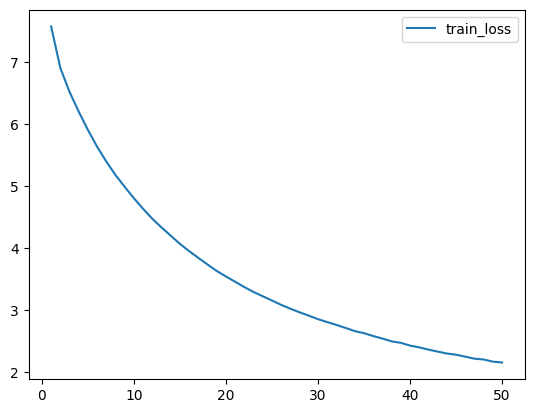

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
# epoch_count = range(1, len(hist2.history['accuracy']) + 1)
# sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
# sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
# plt.show()
epoch_count = range(1, len(hist2.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['loss'], label='train_loss')
plt.show()

Se puede observar que a pesar de haber obtenido una muy mala métrica de perplejidad, el loss al menos converge a 0.


### Predicción de próxima palabra

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

### Generación de secuencias

In [45]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [50]:
input_text='Four arrested'

generate_seq(model2, tok, input_text, max_length=max_context_size, n_words=2)

1/1 [==============================] - 0s 17ms/step


'Four arrested in utah'

###  Beam search y muestreo aleatorio

In [47]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [51]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update))

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens)

    return history_tokens

In [60]:
# predicción con beam search
salidas = beam_search(model2,num_beams=10,num_words=6,input="the war in ukraine")

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


In [61]:
# veamos las salidas
decode(salidas[0])

["the war in ukraine dominates monday's front pages way home"]

### Conclusiones
El modelo elegido (model2) si bien tuvo un loss aceptable y convergente a 0 duarante el entrenamiento, tuvo un muy mal desempeño teniendo en cuenta la métrica de perplejidad. Sin embargo, a la hora de generar secuencias, no performó de la peor manera. Si bien la calidad no es óptima, tiene un nivel regular. Algo que quizas no era esperado dada la pésima métrica de perplejidad. 

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. Es siempre preferible emplear embeddings pre-enternados o modelos pre-entrenados.